# Assignment 6: Neural Network Showdown

Build and compare neural network architectures on image and time-series data.

## Setup

In [5]:
%pip install -q -r requirements.txt

# GPU acceleration (platform-specific)
import platform
if platform.system() == "Darwin" and platform.machine() == "arm64":
    %pip install -q tensorflow-metal

%reset -f

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow-metal (from versions: none)
ERROR: No matching distribution found for tensorflow-metal
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import json
import numpy as np
import pandas as pd

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

# Report available accelerators
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU acceleration: {len(gpus)} device(s)")
    for gpu in gpus:
        print(f"  {gpu.name}")
else:
    print("No GPU detected — using CPU")

from tensorflow import keras
from keras import Sequential
from keras.layers import (
    Dense, Flatten, Dropout, Conv2D, MaxPooling2D, LSTM, Input
)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

from helpers import (
    load_cifar10, load_ecg5000,
    plot_training_history, plot_confusion_matrix,
    plot_sample_images, plot_ecg_traces, plot_predictions,
    CIFAR10_CLASSES, ECG_CLASSES,
)

OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")

No GPU detected — using CPU
Setup complete!


---

## Part 1: Dense Baseline on CIFAR-10

**Task:** Build a Dense (fully connected) network to classify CIFAR-10 images.

CIFAR-10 has 60,000 color images (32x32x3) across 10 classes. A Dense network
flattens each image into 3,072 numbers and classifies from there. This is our
baseline — it ignores spatial structure entirely.

**Architecture requirements:**
- Flatten the input
- At least 2 hidden Dense layers with ReLU activation
- Dropout after each hidden layer
- Output: Dense(10, softmax)

In [7]:
print("Part 1: Dense Baseline on CIFAR-10")
print("-" * 40)

# Load data (normalized to [0,1], one-hot encoded)
X_train, y_train, X_test, y_test = load_cifar10()
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Part 1: Dense Baseline on CIFAR-10
----------------------------------------


/Users/thomasblakely/06-brainiac-thomasblakely/.venv/lib/python3.13/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Train: (50000, 32, 32, 3), Test: (10000, 32, 32, 3)


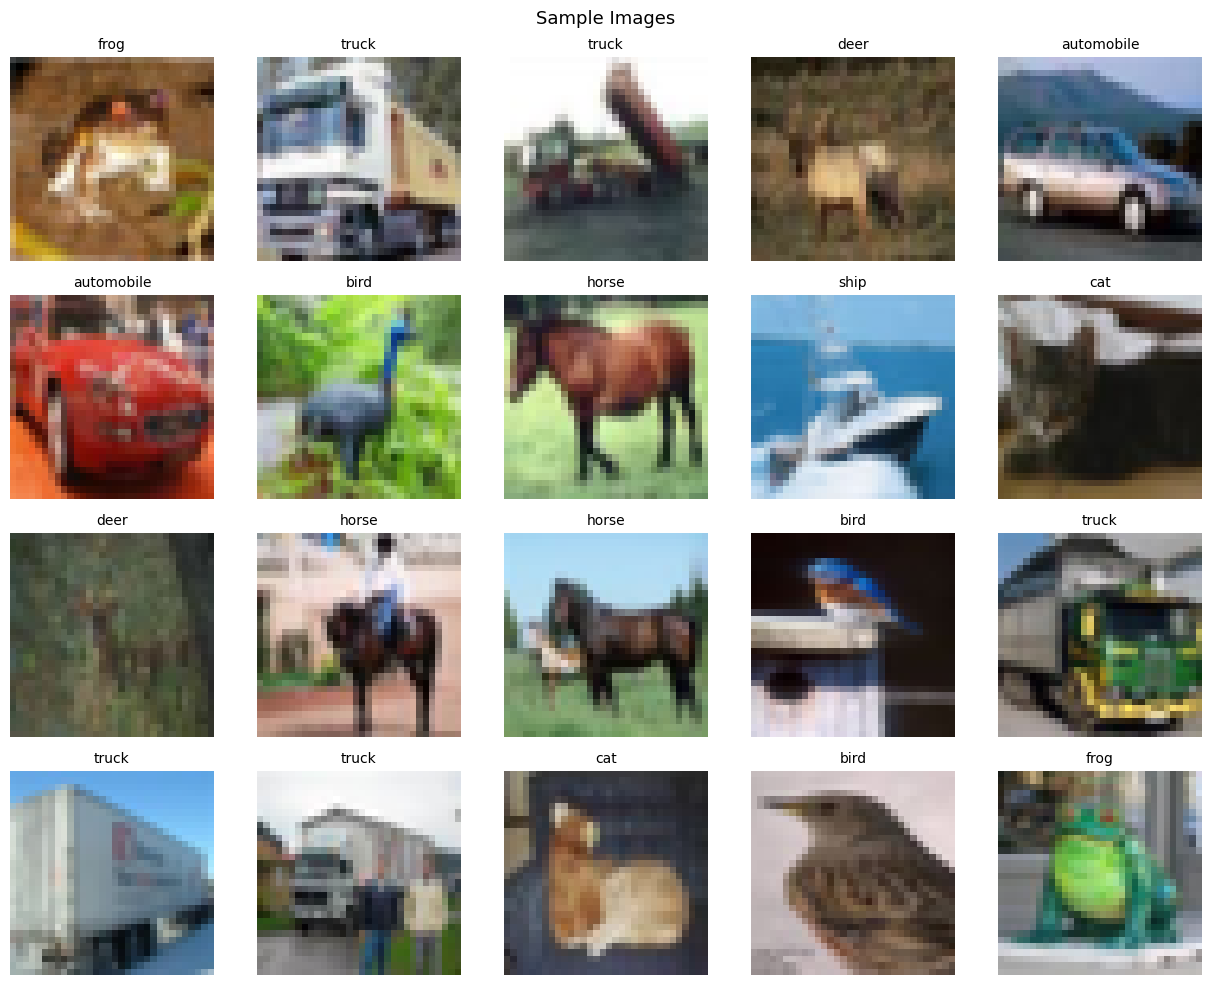

In [8]:
# Visualize some training images to verify data loaded correctly
plot_sample_images(X_train, y_train, CIFAR10_CLASSES)

In [34]:
# Build a Dense model using Sequential
model_dense = Sequential([
    Input(shape=(32, 32, 3)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.4),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(10, activation = 'softmax')
])
model_dense.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,250 (1.53 MB)

 Trainable params: 402,250 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compile the model
model_dense.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [ ]:
# Train with EarlyStopping
early_stop = EarlyStopping(
    monitor = 'val_loss', 
    patience = 3,
    restore_best_weights = True
    )

history_dense = model_dense.fit(
    X_train, y_train,
    epochs = 20, batch_size = 128,
    validation_split = 0.1,
    callbacks = [early_stop]
)  

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1692 - loss: 2.1670 - val_accuracy: 0.2594 - val_loss: 2.0136
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1966 - loss: 2.0927 - val_accuracy: 0.2774 - val_loss: 2.0141
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2151 - loss: 2.0545 - val_accuracy: 0.2906 - val_loss: 1.9503
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2265 - loss: 2.0253 - val_accuracy: 0.2802 - val_loss: 1.9431
Epoch 5/20
 46/352 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2153 - loss: 2.0357

In [12]:
# Evaluate on test set
test_loss, test_acc = model_dense.evaluate(X_test, y_test, verbose = 0)

# Generate predictions and confusion matrix
y_pred = np.argmax(model_dense.predict(X_test, verbose = 0), axis = 1)  
y_true = np.argmax(y_test, axis = 1)  
cm = confusion_matrix(y_true, y_pred)  

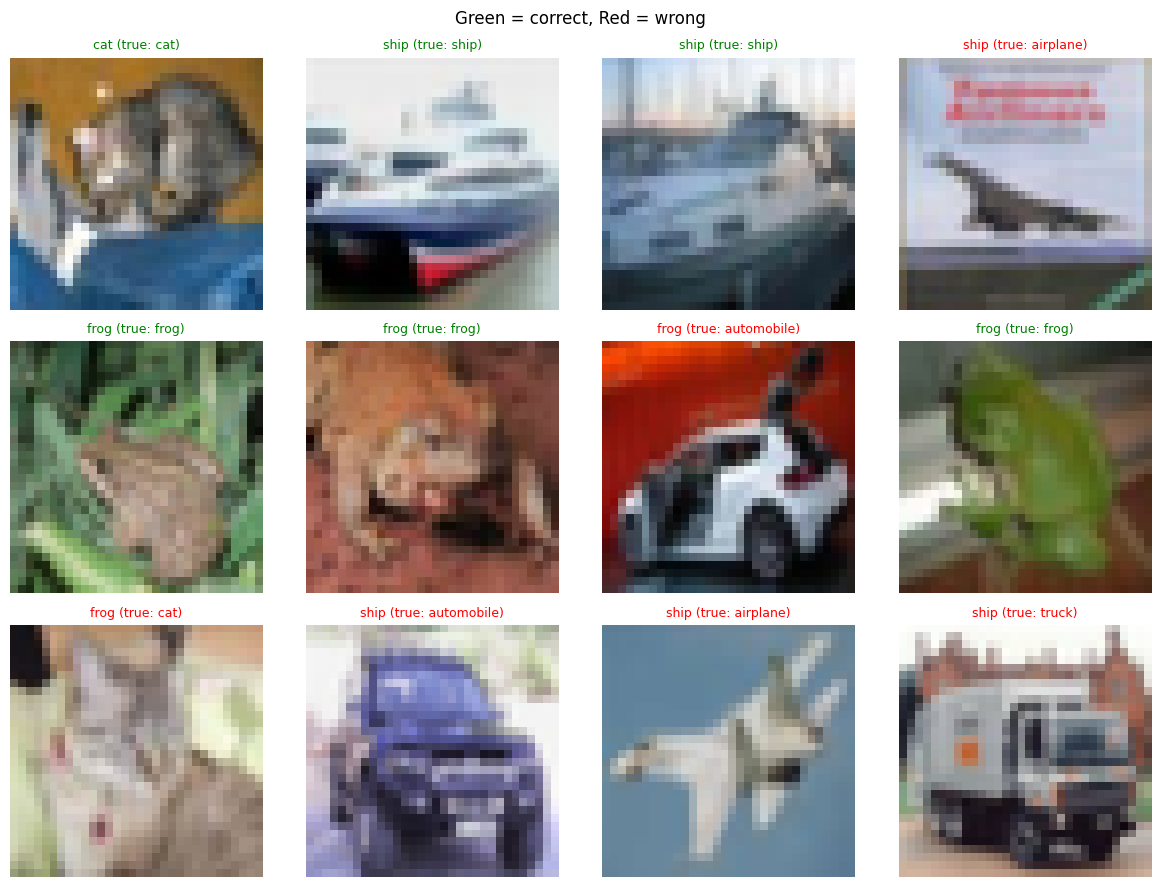

In [13]:
# Optional: visualize predictions and confusion matrix to diagnose issues
plot_predictions(X_test, y_true, y_pred, CIFAR10_CLASSES)
plot_confusion_matrix(y_true, y_pred, list(CIFAR10_CLASSES.values()),
                      os.path.join(OUTPUT_DIR, "part1_confusion_matrix.png"))

In [14]:
# Save results (do not modify this cell)
results = {
    "accuracy": float(test_acc),
    "confusion_matrix": cm.tolist(),
}
with open(os.path.join(OUTPUT_DIR, "part1_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"Dense accuracy: {test_acc:.4f}")
print("Saved output/part1_results.json")

Dense accuracy: 0.1924
Saved output/part1_results.json


---

## Part 2: CNN on CIFAR-10

**Task:** Build a CNN to classify the same CIFAR-10 images. Compare its accuracy
to the Dense baseline from Part 1.

CNNs use convolutional filters that slide across the image, detecting local
patterns (edges, textures, shapes). This preserves spatial structure that
Dense layers discard.

**Architecture requirements:**
- At least 2 Conv2D + MaxPooling2D blocks
- Flatten, then Dense hidden layer with Dropout
- Output: Dense(10, softmax)

In [15]:
print("\nPart 2: CNN on CIFAR-10")
print("-" * 40)

# Data is already loaded from Part 1 (X_train, y_train, X_test, y_test)


Part 2: CNN on CIFAR-10
----------------------------------------


In [16]:
# Build a CNN model using Sequential
model_cnn = Sequential([
    Input(shape = (32, 32, 3)),
    Conv2D(32, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(10, activation = 'softmax')
]) 
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [18]:
# Train with EarlyStopping and ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3,
                  restore_best_weights=True),
    ModelCheckpoint('output/best_cnn.keras',
                    save_best_only=True, monitor='val_accuracy'),
]
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs = 15, 
                            batch_size = 64,
                            validation_split = 0.1,
                            callbacks=callbacks)


Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.4268 - loss: 1.5857 - val_accuracy: 0.5542 - val_loss: 1.2678
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.5566 - loss: 1.2410 - val_accuracy: 0.6280 - val_loss: 1.0727
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6093 - loss: 1.1064 - val_accuracy: 0.6482 - val_loss: 0.9971
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6438 - loss: 1.0182 - val_accuracy: 0.6744 - val_loss: 0.9425
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.6686 - loss: 0.9506 - val_accuracy: 0.6716 - val_loss: 0.9367
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.6883 - loss: 0.8905 - val_accuracy: 0.6882 - val_loss: 0.9022
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7046 - loss: 0.8424 - val_accuracy: 0.6946 - val_loss: 0.8880
Epoch 8/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.7184 - loss: 0.7982 - 

In [19]:
# Plot training history
plot_training_history(history_cnn,
                      os.path.join(OUTPUT_DIR, "part2_training_history.png"))

In [ ]:
# Evaluate on test set
cnn_loss, cnn_acc = model_cnn.evaluate(X_test, y_test, verbose = 0)

# Generate predictions and confusion matrix
y_pred_cnn = np.argmax(model_cnn.predict(X_test, verbose = 0), axis = 1)
y_true_cnn = np.argmax(y_test, axis = 1)
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)

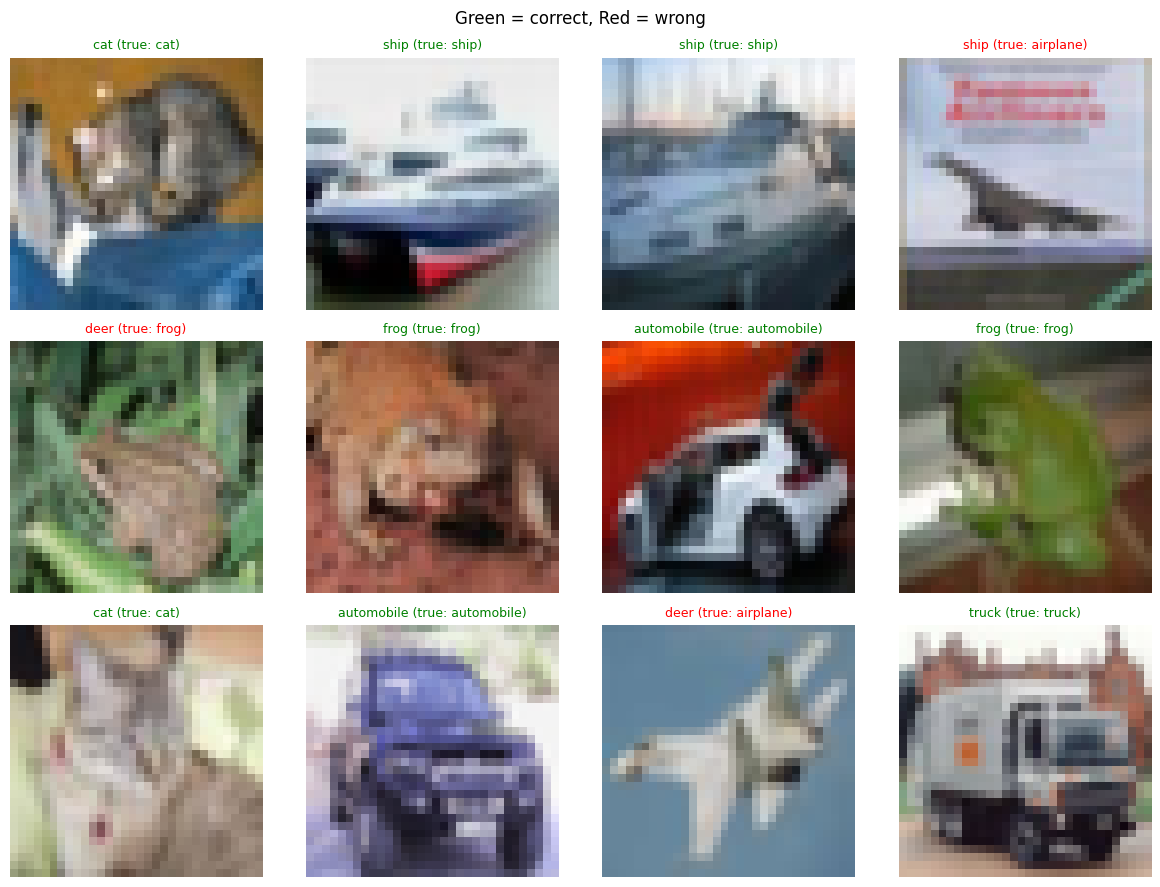

In [21]:
# Optional: visualize predictions and confusion matrix to diagnose issues
plot_predictions(X_test, y_true_cnn, y_pred_cnn, CIFAR10_CLASSES)
plot_confusion_matrix(y_true_cnn, y_pred_cnn, list(CIFAR10_CLASSES.values()),
                      os.path.join(OUTPUT_DIR, "part2_confusion_matrix.png"))

In [22]:
# Save results (do not modify this cell)
results_cnn = {
    "accuracy": float(cnn_acc),
    "confusion_matrix": cm_cnn.tolist(),
}
with open(os.path.join(OUTPUT_DIR, "part2_results.json"), "w") as f:
    json.dump(results_cnn, f, indent=2)

comparison = pd.DataFrame([
    {"model": "Dense", "accuracy": float(test_acc)},
    {"model": "CNN", "accuracy": float(cnn_acc)},
])
comparison.to_csv(os.path.join(OUTPUT_DIR, "part2_comparison.csv"), index=False)

print(f"CNN accuracy:   {cnn_acc:.4f}")
print(f"Dense accuracy: {test_acc:.4f}")
print(f"Improvement:    {cnn_acc - test_acc:+.4f}")
print("Saved output/part2_results.json and output/part2_comparison.csv")

CNN accuracy:   0.6767
Dense accuracy: 0.1924
Improvement:    +0.4843
Saved output/part2_results.json and output/part2_comparison.csv


---

## Part 3: LSTM on ECG5000

**Task:** Build an LSTM to classify heartbeat recordings.

ECG5000 contains 5,000 heartbeat recordings — each is 140 time steps of voltage
measurements, classified into 5 types (Normal, Supraventricular, Premature
Ventricular, Fusion, Unknown). This is sequential data where order matters,
making it a natural fit for recurrent networks.

**Architecture requirements:**
- LSTM layer (any reasonable number of units)
- Dropout for regularization
- Dense output with softmax (5 classes)

In [23]:
print("\nPart 3: LSTM on ECG5000")
print("-" * 40)

# Load ECG data (already shaped for RNN input)
X_train_ecg, y_train_ecg, X_test_ecg, y_test_ecg = load_ecg5000()
print(f"Train: {X_train_ecg.shape}, Test: {X_test_ecg.shape}")
print(f"Classes: {list(ECG_CLASSES.values())}")


Part 3: LSTM on ECG5000
----------------------------------------
Train: (4000, 140, 1), Test: (1000, 140, 1)
Classes: ['Normal', 'Supraventricular', 'Premature Ventricular', 'Fusion', 'Unknown']


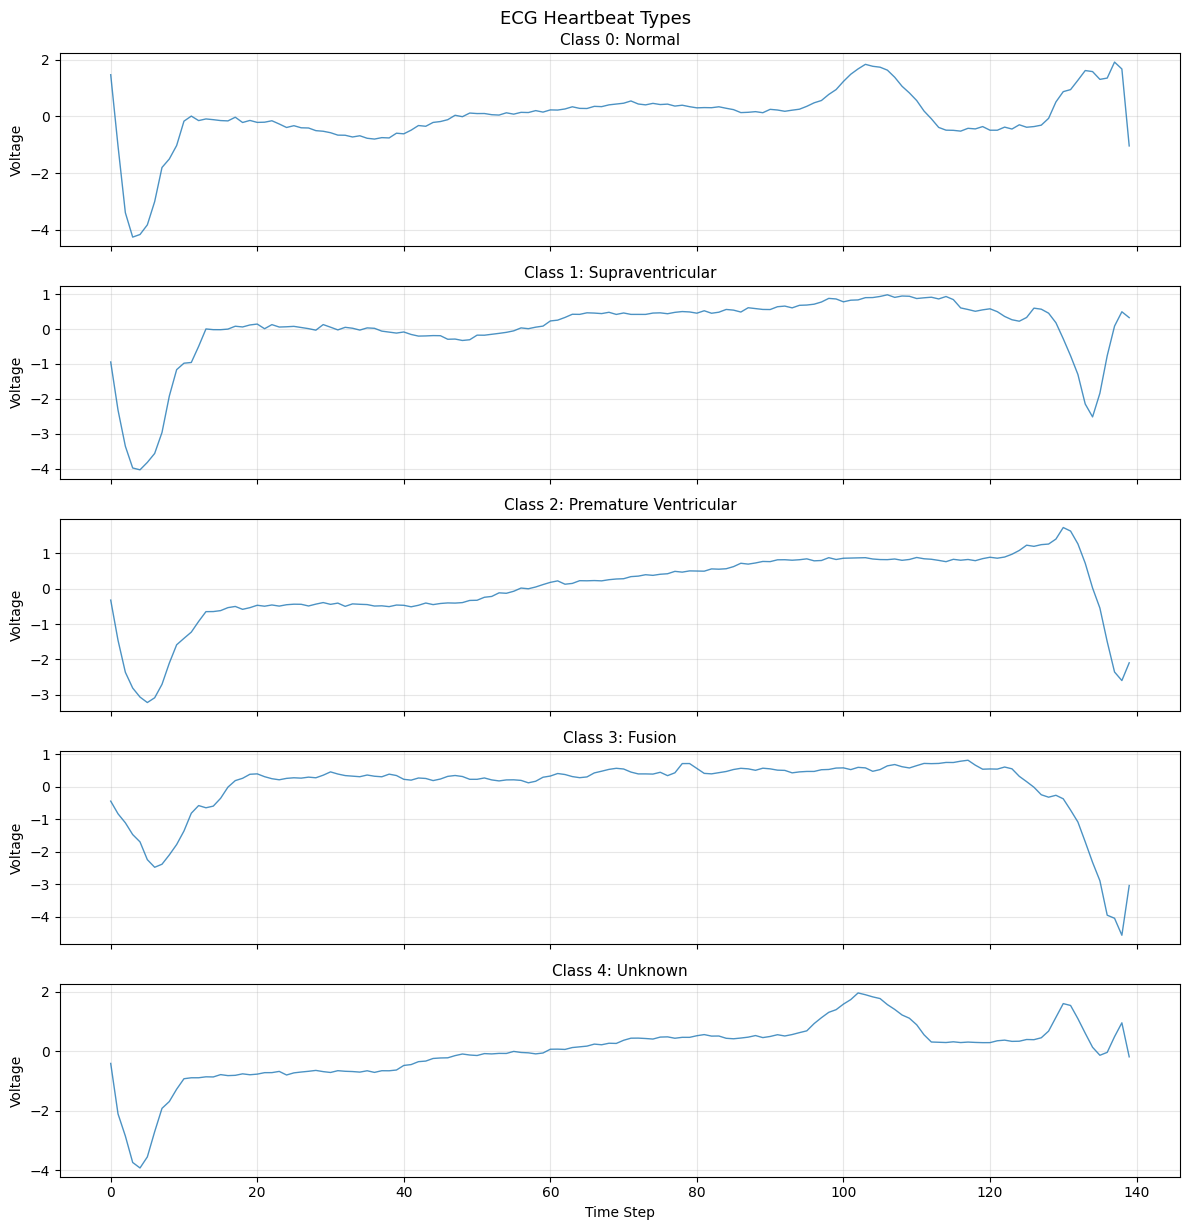

In [24]:
# Visualize ECG traces to understand the data
plot_ecg_traces(X_train_ecg, y_train_ecg, ECG_CLASSES)

In [25]:
# Build an LSTM model using Sequential
model_lstm = Sequential([
    Input(shape=(140, 1)),
    LSTM(64),
    Dropout(0.3),
    Dense(5, activation = 'softmax')
]) 
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,221 (67.27 KB)

 Trainable params: 17,221 (67.27 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Compile the model
model_lstm.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [27]:
# Train with EarlyStopping
early_stop = EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    restore_best_weights = True
    )
history_lstm = model_lstm.fit(
    X_train_ecg, y_train_ecg,
    epochs = 30, batch_size = 32,
    validation_split = 0.1,
    callbacks = [early_stop]
    )

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8872 - loss: 0.5293 - val_accuracy: 0.8925 - val_loss: 0.3534
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9272 - loss: 0.2661 - val_accuracy: 0.9150 - val_loss: 0.3013
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9386 - loss: 0.2331 - val_accuracy: 0.9175 - val_loss: 0.2875
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9406 - loss: 0.2168 - val_accuracy: 0.9200 - val_loss: 0.2777
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9422 - loss: 0.2108 - val_accuracy: 0.9200 - val_loss: 0.2757
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9417 - loss: 0.2061 - val_accuracy: 0.9150 - val_loss: 0.2714
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9439 - loss: 0.2000 - val_accuracy: 0.9250 - val_loss: 0.2534
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9458 - loss: 0.1947 - val_accu

In [28]:
# Plot training history
plot_training_history(history_lstm,
                      os.path.join(OUTPUT_DIR, "part3_training_history.png"))

In [29]:
# Evaluate on test set
lstm_loss, lstm_acc = model_lstm.evaluate(X_test_ecg, y_test_ecg, verbose = 0)

# Generate predictions and confusion matrix
y_pred_ecg = np.argmax(model_lstm.predict(X_test_ecg, verbose = 0), axis = 1)
y_true_ecg = np.argmax(y_test_ecg, axis = 1)
cm_ecg = confusion_matrix(y_true_ecg, y_pred_ecg)

In [30]:
# Optional: visualize confusion matrix to see which heartbeat types are confused
plot_confusion_matrix(y_true_ecg, y_pred_ecg, list(ECG_CLASSES.values()),
                      os.path.join(OUTPUT_DIR, "part3_confusion_matrix.png"))

In [31]:
# Save results (do not modify this cell)
results_ecg = {
    "accuracy": float(lstm_acc),
    "confusion_matrix": cm_ecg.tolist(),
}
with open(os.path.join(OUTPUT_DIR, "part3_results.json"), "w") as f:
    json.dump(results_ecg, f, indent=2)

print(f"LSTM accuracy: {lstm_acc:.4f}")
print("Saved output/part3_results.json")

LSTM accuracy: 0.9380
Saved output/part3_results.json


---

## Validation

In [32]:
print("\nAll parts complete!")
print("Run 'pytest .github/tests/ -v' in your terminal to check your work.")


All parts complete!
Run 'pytest .github/tests/ -v' in your terminal to check your work.
